In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap
from pixelgrid import *
from psfmodel import *

In [2]:
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from jax import random
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import corner

In [4]:
plt.rcParams['figure.dpi'] = 100

In [5]:
#%% obs grid
Nx, Ny = 30, 30
pix = PixelGrid(0, Nx, 0, Ny)

#%% true grid (oversample)
oversample_true = 5
spix = PixelGrid(0, Nx, 0, Ny, dx=1./oversample_true, dy=1./oversample_true)

In [6]:
# conversion from supersampled to observed grid
M, N = spix.X.shape
K, L = oversample_true, oversample_true
MK, NL = M // K, N // L
@jit
def super_to_obs(Zsuper):
    return Zsuper[:MK*K, :NL*L].reshape(MK, K, NL, L).sum(axis=(1, 3))

### S matrix

In [7]:
super_to_obs_1d = lambda Zsuper1d: super_to_obs(Zsuper1d.reshape(M,N)).ravel()
super_to_obs_vmap = jit(vmap(super_to_obs_1d, (0), 1))
Zsupeye = np.eye(M*N)
Smat = super_to_obs_vmap(Zsupeye)

In [8]:
truepsffunc = gaussian_psf

In [9]:
Nsource = 10*2
np.random.seed(124)
xcenters = np.random.rand(Nsource)*Nx
ycenters = np.random.rand(Nsource)*Ny
truepsfkws = {"sigma": 1}

In [10]:
def super_image(spix, xcenters, ycenters, psffunc, **kwargs):
    ret = np.zeros_like(spix.X)
    for x, y in zip(xcenters, ycenters):
        sZ = truepsffunc(spix.X, spix.Y, x, y, **kwargs)
        ret += sZ / jnp.sum(sZ)
    return np.array(ret)

def plot2d(Z, pix, xcenters=None, ycenters=None, title=None):
    plt.imshow(Z, origin='lower', extent=(pix.xmin, pix.xmax, pix.ymin, pix.ymax))
    plt.xlabel("x pixel")
    plt.ylabel("y pixel")
    if xcenters is not None:
        for x, y in zip(xcenters, ycenters):
            plt.axvline(x=x, color='gray', lw=1, alpha=0.5)
            plt.axhline(y=y, color='gray', lw=1, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.colorbar();

In [11]:
Zs = super_image(spix, xcenters, ycenters, truepsffunc, **truepsfkws)

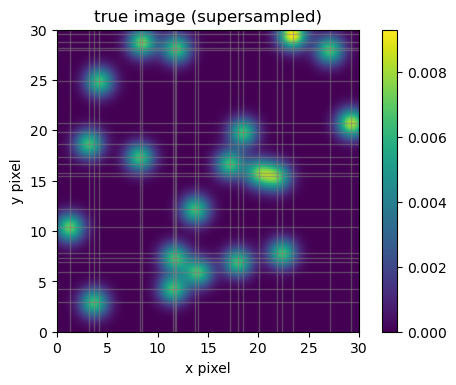

In [12]:
plot2d(Zs, spix, xcenters=xcenters, ycenters=ycenters, title="true image (supersampled)")

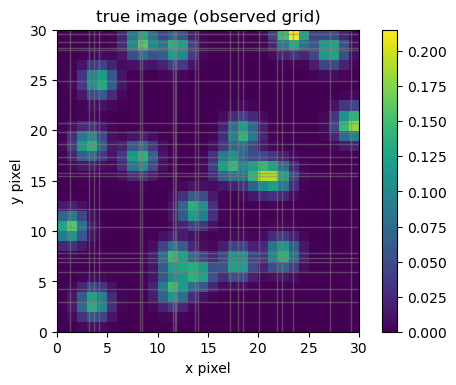

In [13]:
Z = super_to_obs(Zs)
Z_using_mat = jnp.dot(Smat,Zs.ravel()).reshape(Nx,Ny)
plot2d(Z, pix, xcenters=xcenters, ycenters=ycenters, title="true image (observed grid)")

In [14]:
print (np.max(np.abs(Z_using_mat-Z)))

5.551115123125783e-17


In [15]:
np.random.seed(123)
sigmaerr = 2e-3
Zerr = np.random.randn(*np.shape(Z))*sigmaerr
Zobs = Z + Zerr

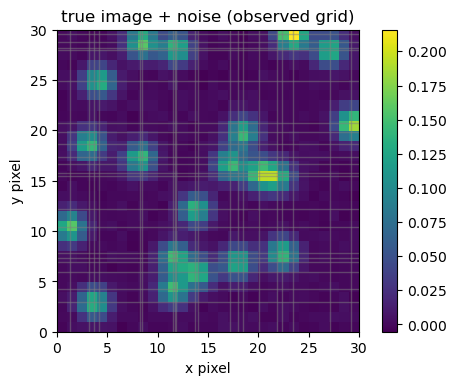

In [16]:
plot2d(Zobs, pix, xcenters=xcenters, ycenters=ycenters, title="true image + noise (observed grid)")

In [17]:
# define supersampled ePSF
xext, yext = 10., 10.
dx, dy = 1., 1.
xext, yext = 7., 7.
dx, dy = 1./3., 1./3.
gpsf = GridPSFModel(xext, yext, dx, dy)
gpsfvalues = vmap(gpsf.psfvalues, (None,None,0,0,None), 0)
gpsfvalues1d = vmap(gpsf.psfvalues1d, (None,None,None,None,0), 1)

PSF grid shape: (21, 21)


In [18]:
trans_matrix = vmap(gpsfvalues1d, (None,None,0,0,None), 0)
paramseye = np.eye(gpsf.Nparams)

In [19]:
f_mean = 1./(gpsf.Nparams*gpsf.ds)

In [20]:
parr = jnp.ones(gpsf.Nparams) * f_mean

In [21]:
jnp.sum(trans_matrix(spix.X, spix.Y, xcenters, ycenters, paramseye)@parr, axis=1)*spix.ds

DeviceArray([0.95559547, 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 0.7616445 , 0.67433766, 0.5657793 ,
             1.        , 0.91640756, 1.        , 0.6086313 , 1.        ,
             1.        , 0.67920984, 1.        , 1.        , 0.72011   ],            dtype=float64)

In [22]:
def gpkernel(gpsf, lenx, leny, lna):
    dx = gpsf.X1d[:,None] - gpsf.X1d[None,:]
    dy = gpsf.Y1d[:,None] - gpsf.Y1d[None,:]
    dx2 = jnp.power(dx / lenx, 2.0)
    dy2 = jnp.power(dy / leny, 2.0)
    cov = jnp.exp(2*lna) * jnp.exp(-0.5*dx2-0.5*dy2)
    return cov

In [39]:
from tinygp import kernels, GaussianProcess
width = 2.
shift = 0.
def gpsfmodel(Z, sigmaerr, gpsf, xcenters, ycenters):
    lnlenx = numpyro.sample("lnlenx", dist.Uniform(low=-2, high=2)) # fail for lnlenx > 0? -> only fcov
    lnleny = numpyro.sample("lnleny", dist.Uniform(low=-2, high=2))
    lna = numpyro.sample("lna", dist.Uniform(low=-10, high=0))
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    fcov = gpkernel(gpsf, lenx, leny, lna)
    
    #mv = dist.MultivariateNormal(loc=0., covariance_matrix=fcov)
    #numpyro.sample("psfvals1d", mv)
    
    ones = jnp.ones_like(xcenters) 
    c = numpyro.sample("c", dist.TruncatedNormal(loc=ones[1:], scale=ones[1:], low=ones[1:]*0.))
    x = numpyro.sample("x", dist.Uniform(low=xcenters[1:]-width, high=xcenters[1:]+width))
    y = numpyro.sample("y", dist.Uniform(low=ycenters[1:]-width, high=ycenters[1:]+width))
    
    carr = jnp.r_[1., c]
    xarr = jnp.r_[xcenters[0]+shift, x]
    yarr = jnp.r_[ycenters[0]+shift, y] 
    Amat = jnp.sum(carr[:,None,None] * trans_matrix(spix.X, spix.Y, xarr, yarr, paramseye), axis=0)
    SA = jnp.dot(Smat, Amat)
    
    cov = jnp.dot(SA, jnp.dot(fcov, SA.T)) + sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    mv = dist.MultivariateNormal(loc=0., covariance_matrix=cov)

    #numpyro.sample("im1d", mv)
    numpyro.sample("obs", mv, obs=Z.ravel())

In [40]:
kernel = numpyro.infer.NUTS(gpsfmodel)

In [41]:
nw, ns = 100, 100
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)

In [42]:
rng_key = random.PRNGKey(0)

In [ ]:
mcmc.run(rng_key, Zobs, sigmaerr, gpsf, xcenters, ycenters)

  0%|                                                                                                               | 0/200 [00:00<?, ?it/s]/home/masuda/anaconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:200: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample:  73%|██████████████████████████████████▎            | 146/200 [1:35:50<44:10, 49.09s/it, 511 steps of size 4.65e-04. acc. prob=0.64]

In [ ]:
mcmc.print_summary()

In [24]:
Ns = Nsource
def params_to_dict(params):
    dic = {}
    c = params[:Ns]
    xc = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yc = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    dic['c'] = np.array(c)
    dic['xcenters'] = np.array(xc)
    dic['ycenters'] = np.array(yc)
    dic['lnlenx'] = float(lnlenx)
    dic['lnleny']= float(lnleny)
    dic['lna'] = float(lna)
    return dic

In [25]:
def gpsfloglike(params, Z, sigmaerr, gpsf):

    carr = jnp.r_[1., params[1:Ns]]
    xarr = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yarr = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)

    fcov = gpkernel(gpsf, lenx, leny, lna)
    
    Amat = jnp.sum(carr[:,None,None] * trans_matrix(spix.X, spix.Y, xarr, yarr, paramseye), axis=0)
    SA = jnp.dot(Smat, Amat)
    cov = jnp.dot(SA, jnp.dot(fcov, SA.T)) + sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    mv = dist.MultivariateNormal(loc=0., covariance_matrix=cov)
    
    return mv.log_prob(Z.ravel())

objective = lambda p: -gpsfloglike(p, Zobs, sigmaerr, gpsf)

In [26]:
def loglikelihood(params, Z1d, sigmaerr):
    #c = params[:Ns]
    c = jnp.r_[1, params[1:Ns]]
    xc = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yc = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    #lnlenx, lnleny, lna = 1., 1., -3.
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    
    dx = gpsf.X1d[:,None] - gpsf.X1d[None,:]
    dy = gpsf.Y1d[:,None] - gpsf.Y1d[None,:]
    dx2 = jnp.power(dx / lenx, 2.0)
    dy2 = jnp.power(dy / leny, 2.0)
    kernel = jnp.exp(2*lna) * jnp.exp(-0.5*dx2-0.5*dy2)

    Amat = c[:,None,None] * trans_matrix(spix.X, spix.Y, xc, yc, paramseye)
    #Amat = jnp.sum(Amat, axis=0)
    Amat = jnp.dot(Smat, jnp.sum(Amat, axis=0))

    cov = jnp.dot(Amat, jnp.dot(kernel, Amat.T))
    cov += sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    
    SinvZ = jnp.linalg.solve(cov, Z1d)

    #return -0.5 * len(Z1d) * jnp.linalg.slogdet(cov)[1] - 0.5 * jnp.dot(Z1d.T, SinvZ)
    return -0.5 * jnp.linalg.slogdet(cov)[1] - 0.5 * jnp.dot(Z1d.T, SinvZ) - 0.5 * len(Z1d) * jnp.log(2*jnp.pi)

#objective = lambda p: -loglikelihood(p, Zobs.ravel(), sigmaerr)

In [27]:
width = 2.
shift = 0.
params = np.array([1.]*Ns + list(xcenters[1:]-1.*0.5) + list(ycenters[1:]+1.*0.5) + [0, 0, -5])
params_lower = [0]*Ns + list(xcenters[1:]-width) + list(ycenters[1:]-width) + [-5+3, -5+3, -10.]
params_upper = [10]*Ns + list(xcenters[1:]+width) + list(ycenters[1:]+width) + [2., 2., 0.]
bounds = (params_lower, params_upper)

In [28]:
import jaxopt
method = "TNC"
#method = "Nelder-Mead"
solver = jaxopt.ScipyBoundedMinimize(fun=objective, method=method)#, options={'gtol': 1e-100, 'maxfun': 10000})

In [31]:
%time loglikelihood(params, Zobs.ravel(), sigmaerr)

CPU times: user 44.9 ms, sys: 4.29 ms, total: 49.2 ms
Wall time: 33.6 ms


DeviceArray(51.46077698, dtype=float64)

In [32]:
%time gpsfloglike(params, Zobs, sigmaerr, gpsf)

CPU times: user 26.5 ms, sys: 973 µs, total: 27.5 ms
Wall time: 14.8 ms


DeviceArray(51.46077696, dtype=float64)

In [33]:
def show_res(res):
    print ()
    print (res)
    popt, state = res
    pdict = params_to_dict(popt)
    xmean = pdict['xcenters'][1:]
    ymean = pdict['ycenters'][1:]
    dx = xmean - xcenters[1:]
    dy = ymean - ycenters[1:]
    print ("# dx = %.3f +/- %.3f"%(np.mean(dx),np.std(dx)))
    print ("# dy = %.3f +/- %.3f"%(np.mean(dy),np.std(dy)))
    return popt, pdict

In [34]:
%%time
res = solver.run(params, bounds=bounds)
popt, pdict = show_res(res)


OptStep(params=DeviceArray([ 1.        ,  0.99531886,  0.99700817,  0.98541533,
              0.98062084,  1.00231161,  1.02141341,  1.01652143,
              1.10979724,  1.46881486,  0.98236048,  0.99738013,
              0.98930058,  1.28933397,  0.99604169,  0.98421771,
              1.1032183 ,  0.98186263,  0.99682869,  1.02803203,
             22.35681186, 17.15454593, 13.7258211 , 11.53347734,
              8.20667994, 20.04808286, 11.83459277,  8.44706297,
             23.39100211, 17.97043347,  3.6973126 , 11.67742923,
             29.26753435, 14.00776199,  4.20700811,  1.25407037,
             21.85730728, 18.47942136, 27.06931725,  7.78249046,
             16.65656196, 12.14016031,  4.24101433, 17.30344046,
             15.77156077, 28.14661467, 28.77903669, 29.54937616,
              6.91399316,  2.92215149,  7.36367522, 20.70643377,
              5.8943313 , 24.87983611, 10.39014489, 15.42020186,
             19.81821845, 27.99588991,  0.2523859 ,  0.31142902,
         

In [35]:
for i in range(3):
    res = solver.run(popt, bounds=bounds)
    popt, pdict = show_res(res)


OptStep(params=DeviceArray([ 1.        ,  0.99531896,  0.99700826,  0.98541544,
              0.98062103,  1.00231173,  1.02141338,  1.01652152,
              1.10979736,  1.46881502,  0.98236059,  0.99738023,
              0.98930072,  1.28933411,  0.99604189,  0.98421782,
              1.10321842,  0.98186286,  0.99682879,  1.02803216,
             22.35681186, 17.15454603, 13.72582117, 11.53347732,
              8.20668   , 20.04808276, 11.83459287,  8.44706315,
             23.39100194, 17.97043357,  3.69731266, 11.67742923,
             29.26753432, 14.00776204,  4.20700822,  1.2540704 ,
             21.85730724, 18.47942138, 27.06931743,  7.78249048,
             16.656562  , 12.14016032,  4.24101426, 17.30344048,
             15.77156069, 28.14661457, 28.77903673, 29.54937612,
              6.91399321,  2.9221515 ,  7.36367539, 20.70643378,
              5.89433132, 24.87983615, 10.39014487, 15.42020193,
             19.81821847, 27.99588979,  0.25238591,  0.31142902,
         

In [36]:
for k in pdict.keys():
    print ("%s\t%s"%(k, pdict[k]))

c	[1.         0.99531898 0.99700822 0.98541547 0.98062105 1.00231176
 1.021413   1.01652155 1.10979739 1.46881505 0.98236062 0.99738026
 0.9893007  1.28933415 0.99604192 0.98421785 1.10321845 0.98186329
 0.99682882 1.02803217]
xcenters	[ 3.18194718 22.35681216 17.15454618 13.72582144 11.53347759  8.20668031
 20.04808245 11.83459321  8.44706345 23.39100233 17.97043387  3.69731294
 11.67742948 29.26753461 14.00776225  4.20700851  1.25407068 21.85730697
 18.47942168 27.0693177 ]
ycenters	[18.67900243  7.78249049 16.65656208 12.14016033  4.24101431 17.30344049
 15.77156076 28.14661457 28.77903672 29.54937612  6.91399323  2.92215151
  7.36367544 20.70643378  5.89433134 24.87983616 10.39014488 15.42020209
 19.81821849 27.99588981]
lnlenx	0.25238598538474044
lnleny	0.3114290289929813
lna	-6.740199256714786


In [37]:
xmean = pdict['xcenters'][1:]
ymean = pdict['ycenters'][1:]
xstd, ystd = 0*xmean, 0*ymean
dmax = np.r_[np.abs(xmean-xcenters[1:]-shift)+np.abs(xstd), np.abs(ymean-ycenters[1:]-shift)+np.abs(ystd)].max()
print (np.mean(xmean-xcenters[1:]), np.mean(ymean-ycenters[1:]))

-0.00458607892250707 -0.009131610423426707


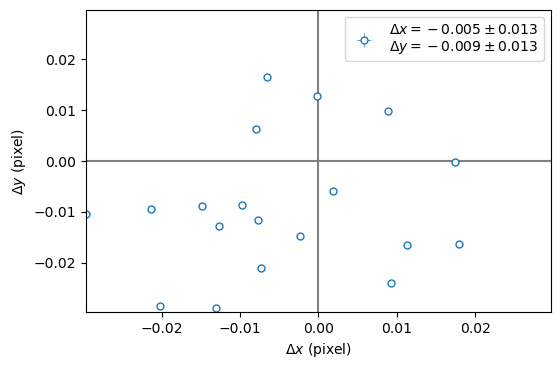

In [38]:
plt.figure()
plt.xlabel("$\Delta x$ (pixel)")
plt.ylabel("$\Delta y$ (pixel)")
plt.xlim(-dmax, dmax)
plt.ylim(-dmax, dmax)
plt.axvline(x=0, color='gray', zorder=-1000)
plt.axhline(y=0, color='gray', zorder=-1000)
dx = xmean-xcenters[1:]-shift
dy = ymean-ycenters[1:]-shift
plt.errorbar(dx, dy, xerr=xstd, yerr=ystd, fmt='o', mfc='white', lw=0.5, markersize=5,
            label="$\Delta x=%.3f\pm%.3f$\n$\Delta y=%.3f\pm%.3f$"%(np.mean(dx), np.std(dx), np.mean(dy), np.std(dy)))
plt.legend(loc='best', bbox_to_anchor=(1,1))